In [54]:
import pandas as pd
import numpy as np
import requests
import re
import time
import bs4
import json
import tqdm
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from skopt import forest_minimize

In [6]:
queries = [
    'deep+learning', 'machine+learning', 'numpy+for+data+science',
    'tensorflow', 'data+science', 'tensorflow+2.0'
]
url = 'https://www.youtube.com/results?search_query={query}&sp=CAI%253D&p={page}'

In [7]:
for query in tqdm.tqdm_notebook(queries):
    for page in tqdm.tqdm_notebook(range(1, 30)):
        response = requests.get(url.format(query=query, page=page))
        page_html = response.text
        parsed = bs4.BeautifulSoup(page_html)
        tags = parsed.findAll('a')

        for tag in tags:
            if tag.has_attr('aria-describedby'):
                link = tag['href']
                title = tag['title']
                with open('data/parsed_video.json', 'a+') as out:
                    data = {"link": link, "title": title, "query": query}
                    out.write(f'{json.dumps(data)}\n')

In [8]:
df = pd.read_json('data/parsed_video.json', lines=True, orient='records')
df.head()

,link,title,query
0,/watch?v=ftMq5ps503w,How to Predict Stock Prices Easily - Intro to ...,deep+learning
1,/watch?v=5cFUZ03Sbhc,Why Machine Learning is The Future? | Sundar P...,deep+learning
2,/watch?v=cAICT4Al5Ow,How to Make an Image Classifier - Intro to Dee...,deep+learning
3,/watch?v=mWl45NkFBOc,TensorFlow: Machine Learning for Everyone,deep+learning
4,/watch?v=xl3yQBhI6vY,Machine Learning and Prediction in Economics a...,deep+learning


In [9]:
url_video = 'https://www.youtube.com{link}'

In [10]:
for _link in tqdm.tqdm_notebook(df['link'].unique()):
    response = requests.get(url_video.format(link=_link))
    page_html = response.text
    parsed = bs4.BeautifulSoup(page_html, 'html.parser')
    class_watch = parsed.findAll(attrs={'class': re.compile(r'watch')})
    id_watch = parsed.findAll(attrs={'id': re.compile(r'watch')})
    channel = parsed.findAll('a', attrs={'href': re.compile(r'channel')})
    meta = parsed.findAll('meta')

    data = {}

    for _class in class_watch:
        colname = '_'.join(_class['class'])
        if 'clearfix' not in colname:
            data[colname] = _class.text.strip()

    for _id in id_watch:
        colname = _id['id']
        data[colname] = _id.text.strip()

    for _meta in meta:
        colname = _meta.get('property')
        if colname is not None:
            data[colname] = _meta['content']

    for i, _channel in enumerate(channel):
        data[f'channel_link_{i}'] = _channel['href']

    with open('data/parsed_video_info.json', 'a+') as out:
        out.write(f'{json.dumps(data)}\n')

In [11]:
df_info = pd.read_json('data/parsed_video_info.json',
                       lines=True,
                       orient='records')
df_info.head(2)

,content-alignment_watch-small,watch-playlist_player-height,watch-queue-header,watch-queue-info,watch-queue-info-icon,watch-queue-title,watch-queue-control-bar_control-bar-button,watch-queue-mole-info,watch-queue-control-bar-icon,watch-queue-icon_yt-sprite,...,channel_link_12,channel_link_13,channel_link_14,channel_link_15,channel_link_16,channel_link_17,channel_link_18,channel_link_19,channel_link_20,channel_link_21
0,Este vídeo não está disponível.\n\n \n\n\n\...,Fila de exibiçãoFilaFila de exibiçãoFila \nRem...,Fila de exibiçãoFilaFila de exibiçãoFila \nRem...,Fila de exibiçãoFila,,Fila de exibição,Fila de exibiçãoFila \nRemover todosDesconectar,Fila de exibiçãoFila,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Este vídeo não está disponível.\n\n \n\n\n\...,Fila de exibiçãoFilaFila de exibiçãoFila \nRem...,Fila de exibiçãoFilaFila de exibiçãoFila \nRem...,Fila de exibiçãoFila,,Fila de exibição,Fila de exibiçãoFila \nRemover todosDesconectar,Fila de exibiçãoFila,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_info.columns

Index(['content-alignment_watch-small', 'watch-playlist_player-height',
       'watch-queue-header', 'watch-queue-info', 'watch-queue-info-icon',
       'watch-queue-title', 'watch-queue-control-bar_control-bar-button',
       'watch-queue-mole-info', 'watch-queue-control-bar-icon',
       'watch-queue-icon_yt-sprite',
       ...
       'channel_link_12', 'channel_link_13', 'channel_link_14',
       'channel_link_15', 'channel_link_16', 'channel_link_17',
       'channel_link_18', 'channel_link_19', 'channel_link_20',
       'channel_link_21'],
      dtype='object', length=171)

In [13]:
columns = [
    'watch-title', 'watch-view-count', 'watch-time-text',
    'content_watch-info-tag-list', 'watch7-headline', 'watch7-user-header',
    'watch8-sentiment-actions', 'og:image', 'og:image:width',
    'og:image:height', 'og:description', 'og:video:width', 'og:video:height',
    'og:video:tag', 'channel_link_0'
]

In [14]:
df_filtered = df_info[columns]

In [15]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 15 columns):
watch-title                    1916 non-null object
watch-view-count               1890 non-null object
watch-time-text                1916 non-null object
content_watch-info-tag-list    1903 non-null object
watch7-headline                1916 non-null object
watch7-user-header             1916 non-null object
watch8-sentiment-actions       1890 non-null object
og:image                       2017 non-null object
og:image:width                 2017 non-null int64
og:image:height                2017 non-null int64
og:description                 2017 non-null object
og:video:width                 1997 non-null float64
og:video:height                1997 non-null float64
og:video:tag                   1801 non-null object
channel_link_0                 1916 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 236.5+ KB


In [16]:
df_filtered.columns

Index(['watch-title', 'watch-view-count', 'watch-time-text',
       'content_watch-info-tag-list', 'watch7-headline', 'watch7-user-header',
       'watch8-sentiment-actions', 'og:image', 'og:image:width',
       'og:image:height', 'og:description', 'og:video:width',
       'og:video:height', 'og:video:tag', 'channel_link_0'],
      dtype='object')

In [17]:
df_filtered.dropna(subset=['watch-time-text'], inplace=True)

month_map = {
    "jan": "Jan",
    "fev": "Feb",
    "mar": "Mar",
    "abr": "Apr",
    "mai": "May",
    "jun": "Jun",
    "jul": "Jul",
    "ago": "Aug",
    "set": "Sep",
    "out": "Oct",
    "nov": "Nov",
    "dez": "Dec"
}

clean_date = df_filtered['watch-time-text'].str.extract(
    r"(\d+) de ([a-z]+)\. de (\d+)")

df_filtered = df_filtered[~clean_date[0].isna()]
clean_date = clean_date[~clean_date[0].isna()]

clean_date[0] = clean_date[0].map(lambda x: "0" + x[0] if len(x) == 1 else x)
clean_date[1] = clean_date[1].map(month_map)
clean_date = clean_date.apply(lambda x: " ".join(x), axis=1)

df_filtered['watch-time-text'] = pd.to_datetime(clean_date, format="%d %b %Y")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_filtered.head(2)

,watch-title,watch-view-count,watch-time-text,content_watch-info-tag-list,watch7-headline,watch7-user-header,watch8-sentiment-actions,og:image,og:image:width,og:image:height,og:description,og:video:width,og:video:height,og:video:tag,channel_link_0
0,How to Predict Stock Prices Easily - Intro to ...,586.962 visualizações,2017-02-24,Educação,How to Predict Stock Prices Easily - Intro to ...,Siraj Raval\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nCarre...,586.962 visualizações\n\n\n\n\n\n\n\n7.784\n\n...,https://i.ytimg.com/vi/ftMq5ps503w/hqdefault.jpg,480,360,We're going to predict the closing price of th...,1280.0,720.0,stock,/channel/UCWN3xxRkmTPmbKwht9FuE5A
1,Why Machine Learning is The Future? | Sundar P...,776.795 visualizações,2017-02-21,Ciência e tecnologia,Why Machine Learning is The Future? | Sundar P...,ACADGILD\n\n\n\n\n\n\n\n\n\n\n\n\n\nCarregando...,776.795 visualizações\n\n\n\n\n\n\n\n7.009\n\n...,https://i.ytimg.com/vi/5cFUZ03Sbhc/maxresdefau...,1280,720,Why Machine Learning is The Future? | Sundar P...,640.0,360.0,Sundhar pichai talks about machine learning,/channel/UCaQfgvMsjpImSxrJQDBjd-Q


In [19]:
df_filtered['watch-view-count'] = df_filtered['watch-view-count'].str.extract(
    r"(\d+\.?\d*)", expand=False).str.replace(".", "").fillna(0).astype(int)

In [20]:
df_filtered.head(2)

,watch-title,watch-view-count,watch-time-text,content_watch-info-tag-list,watch7-headline,watch7-user-header,watch8-sentiment-actions,og:image,og:image:width,og:image:height,og:description,og:video:width,og:video:height,og:video:tag,channel_link_0
0,How to Predict Stock Prices Easily - Intro to ...,586962,2017-02-24,Educação,How to Predict Stock Prices Easily - Intro to ...,Siraj Raval\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nCarre...,586.962 visualizações\n\n\n\n\n\n\n\n7.784\n\n...,https://i.ytimg.com/vi/ftMq5ps503w/hqdefault.jpg,480,360,We're going to predict the closing price of th...,1280.0,720.0,stock,/channel/UCWN3xxRkmTPmbKwht9FuE5A
1,Why Machine Learning is The Future? | Sundar P...,776795,2017-02-21,Ciência e tecnologia,Why Machine Learning is The Future? | Sundar P...,ACADGILD\n\n\n\n\n\n\n\n\n\n\n\n\n\nCarregando...,776.795 visualizações\n\n\n\n\n\n\n\n7.009\n\n...,https://i.ytimg.com/vi/5cFUZ03Sbhc/maxresdefau...,1280,720,Why Machine Learning is The Future? | Sundar P...,640.0,360.0,Sundhar pichai talks about machine learning,/channel/UCaQfgvMsjpImSxrJQDBjd-Q


In [21]:
df_filtered['days_published'] = (pd.to_datetime('today') -
                                 df_filtered['watch-time-text']).dt.days + 1

In [22]:
df_filtered['days_published'].describe()

count    1912.000000
mean      429.000000
std       369.840342
min         1.000000
25%       128.750000
50%       356.000000
75%       664.000000
max      2471.000000
Name: days_published, dtype: float64

In [23]:
df_filtered['view_per_day'] = df_filtered['watch-view-count'] // df_filtered[
    'days_published']

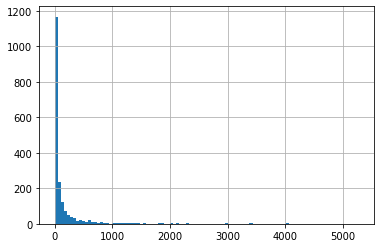

In [24]:
df_filtered['view_per_day'].hist(bins=100)

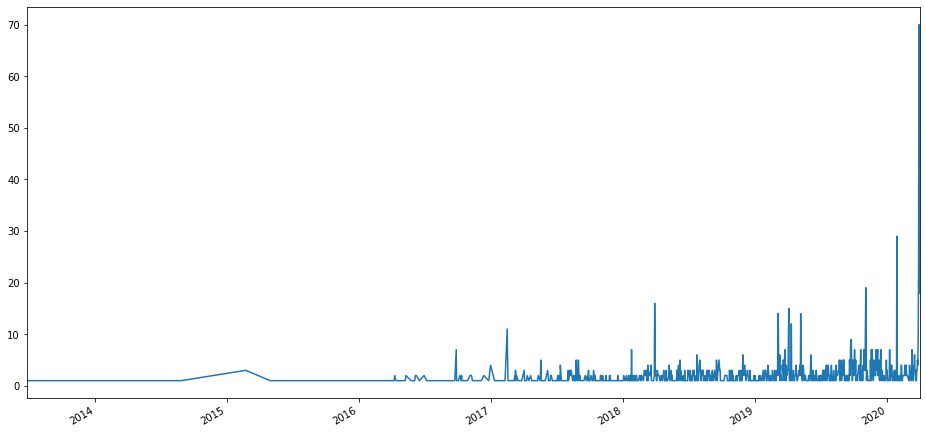

In [25]:
df_filtered['watch-time-text'].value_counts().plot(figsize=(16, 8))

In [26]:
df_filtered['like'] = df_filtered['watch8-sentiment-actions'].str.extract(
    r"\n(\d+)").fillna(0).astype(int)

In [27]:
df_filtered['like'].describe()

count    1912.000000
mean      142.473849
std       220.943525
min         0.000000
25%         3.000000
50%        26.000000
75%       198.250000
max       991.000000
Name: like, dtype: float64

In [28]:
df_likes = df_filtered['watch8-sentiment-actions'].str.findall(r"\n(\d+)\n")
df_likes = df_likes.apply(lambda x: (0, 0) if type(x) != list or len(x) != 3
                          else (int(x[0]), int(x[2])))
df_likes = pd.DataFrame(df_likes.tolist(), columns=['likes', 'dislikes'])

In [29]:
df_filtered = df_filtered.reset_index()

In [30]:
df_filtered['likes'] = df_likes['likes']
df_filtered['dislikes'] = df_likes['dislikes']

In [31]:
df_filtered['likes'].describe()

count    1912.000000
mean      140.049686
std       221.543376
min         0.000000
25%         0.000000
50%        21.000000
75%       195.000000
max       991.000000
Name: likes, dtype: float64

In [32]:
df_filtered['dislikes'].describe()

count    1912.000000
mean        4.654812
std        14.633070
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max       341.000000
Name: dislikes, dtype: float64

In [33]:
df_filtered['target'] = (df_filtered['likes'] >= df_filtered['likes'].quantile(
    0.75)) & (df_filtered['likes'] >= df_filtered['dislikes'] * 3)

In [34]:
df_filtered['target'].value_counts()

False    1436
True      476
Name: target, dtype: int64

In [35]:
X = df_filtered[['watch-view-count', 'view_per_day']]
y = df_filtered[['target']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)

In [ ]:
model = DecisionTreeClassifier(random_state=0,
                               max_depth=2,
                               class_weight='balanced')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
predict = model.predict_proba(X_test)
print(f'AVG precision: {average_precision_score(y_test, predict[:, 1])}')
print(f'ROC AUC: {roc_auc_score(y_test, predict[:, 1])}')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plot_tree(model, ax=ax, feature_names=X_train.columns)

In [ ]:
tfidf = TfidfVectorizer(min_df=2)
matriz_words = tfidf.fit_transform(df_filtered['watch-title'])

In [ ]:
X = hstack([df_filtered[['watch-view-count', 'view_per_day']], matriz_words])
y = df_filtered[['target']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)

In [ ]:
model_rfc = RandomForestClassifier(n_estimators=1000,
                                   class_weight='balanced',
                                   n_jobs=6,
                                   random_state=0)

In [ ]:
model_rfc.fit(X_train, y_train)

In [ ]:
predict = model_rfc.predict_proba(X_test)
print(f'AVG precision: {average_precision_score(y_test, predict[:, 1])}')
print(f'ROC AUC: {roc_auc_score(y_test, predict[:, 1])}')

## Active Learning

Rotulamos apenas uma parte do dataset, treinamos a rede com esse dataset. Pegamos a outra parte do dataset que não foi rotulada, coloca na rede e as previsões que a rede ficar confusa (proximo a 50%) rotulamos na mão novamente, assim ganhamos o beneficio de diminuir a rotulação.

In [ ]:
from skopt import forest_minimize
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from scipy.sparse import csr_matrix

In [ ]:
maxAbs = MaxAbsScaler()
stdScaler = StandardScaler()
X_abs = maxAbs.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
X_abs = stdScaler.fit_transform(
    df_filtered[['watch-view-count', 'view_per_day']])
y = df_filtered[['target']]

In [ ]:
def tune_forest(params):
    print(params)
    max_depth = params[0]
    n_estimators = params[1]

    min_df = params[2]
    ngram_range = (1, params[3])

    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    matriz_words = title_vec.fit_transform(df_filtered['watch-title'])

    stdScaler = StandardScaler()
    X = stdScaler.fit_transform(
        df_filtered[['watch-view-count', 'view_per_day']])
    X = hstack([X, matriz_words])
    y = df_filtered[['target']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.15,
                                                        random_state=42)

    mdl = RandomForestClassifier(max_depth=max_depth,
                                 n_estimators=n_estimators,
                                 class_weight='balanced',
                                 n_jobs=6,
                                 random_state=0)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_test)[:, 1]

    print(
        f'AVG precision: {average_precision_score(y_test, p)} - ROC AUC: {roc_auc_score(y_test, p)}'
    )

    return -average_precision_score(y_test, p)


space = [
    (1, 10),  # max_depth
    (100, 1000),  # n_estimators
    (1, 5),  # min_df
    (1, 5)
]  # ngram_range

res_forest = forest_minimize(tune_forest,
                             space,
                             random_state=160745,
                             n_random_starts=20,
                             n_calls=50,
                             verbose=1)

In [ ]:
params = res_forest.x

max_depth = params[0]
n_estimators = params[1]

min_df = params[2]
ngram_range = (1, params[3])

title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
matriz_words = title_vec.fit_transform(df_filtered['watch-title'])
    
stdScaler = StandardScaler()
X = stdScaler.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
X = hstack([X, matriz_words])
y = df_filtered[['target']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)
    
model_forest = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, class_weight='balanced',
                                 n_jobs=6, random_state=0)
    
model_forest.fit(X_train, y_train)
    
predict_forest = model_forest.predict_proba(X_test)[:, 1]
    
print(f'AVG precision: {average_precision_score(y_test, predict_forest)} - ROC AUC: {roc_auc_score(y_test, predict_forest)}')

In [ ]:
def tune_logistic(params):
    print(params)
    c = params[0]
    penalty = params[1]
    
    min_df = params[2]
    ngram_range = (1, params[3])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    matriz_words = title_vec.fit_transform(df_filtered['watch-title'])
    
    stdScaler = StandardScaler()
    X = stdScaler.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
    X = hstack([X, matriz_words])
    y = df_filtered[['target']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)
    
    mdl = LogisticRegression(C=c, class_weight='balanced', n_jobs=6, random_state=0, penalty=penalty)
    
    mdl.fit(X_train, y_train)
    
    p = mdl.predict_proba(X_test)[:, 1]
    print(f'AVG precision: {average_precision_score(y_test, p)} - ROC AUC: {roc_auc_score(y_test, p)}')
    
    return -average_precision_score(y_test, p)


space = [(0.001, 1000), # c
         ('l1', 'l2'),
          (1,5), # min_df
          (1,5)] # ngram_range

res_logistic = forest_minimize(tune_logistic, space, random_state=160745, n_random_starts=20, n_calls=200, verbose=1)


In [ ]:
params = res_logistic.x

c = params[0]
penalty = params[1]

min_df = params[2]
ngram_range = (1, params[3])
    
title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
matriz_words = title_vec.fit_transform(df_filtered['watch-title'])
    
stdScaler = StandardScaler()
X = stdScaler.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
X = hstack([X, matriz_words])
y = df_filtered[['target']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)
    
model_logistic = LogisticRegression(C=c, class_weight='balanced', n_jobs=6, random_state=0, penalty=penalty)
    
model_logistic.fit(X_train, y_train)
    
predict_logistic = model_logistic.predict_proba(X_test)[:, 1]
print(f'AVG precision: {average_precision_score(y_test, predict_logistic)} - ROC AUC: {roc_auc_score(y_test, predict_logistic)}')

In [ ]:
df_predict = pd.DataFrame({'logistic': predict_logistic, 'forest': predict_forest})

In [ ]:
df_predict.corr()

In [ ]:
print(f'AVG precision: {average_precision_score(y, predict_logistic)} - ROC AUC: {roc_auc_score(y_test, predict_logistic)}')

In [36]:
print(f'AVG precision: {average_precision_score(y, predict_logistic)} - ROC AUC: {roc_auc_score(y_test, predict_logistic)}')

In [37]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [38]:
predict = model.predict_proba(X_test)
print(f'AVG precision: {average_precision_score(y_test, predict[:, 1])}')
print(f'ROC AUC: {roc_auc_score(y_test, predict[:, 1])}')

AVG precision: 0.5135788219917363
ROC AUC: 0.855291723202171


[Text(446.4, 453.0, 'watch-view-count <= 4405.5\ngini = 0.5\nsamples = 1625\nvalue = [812.5, 812.5]'),
 Text(223.2, 271.8, 'view_per_day <= 403.5\ngini = 0.027\nsamples = 654\nvalue = [434.981, 5.96]'),
 Text(111.6, 90.59999999999997, 'gini = 0.018\nsamples = 648\nvalue = [431.641, 3.973]'),
 Text(334.79999999999995, 90.59999999999997, 'gini = 0.468\nsamples = 6\nvalue = [3.341, 1.987]'),
 Text(669.5999999999999, 271.8, 'watch-view-count <= 77305.0\ngini = 0.434\nsamples = 971\nvalue = [377.519, 806.54]'),
 Text(558.0, 90.59999999999997, 'gini = 0.325\nsamples = 681\nvalue = [197.111, 766.809]'),
 Text(781.1999999999999, 90.59999999999997, 'gini = 0.296\nsamples = 290\nvalue = [180.407, 39.731]')]

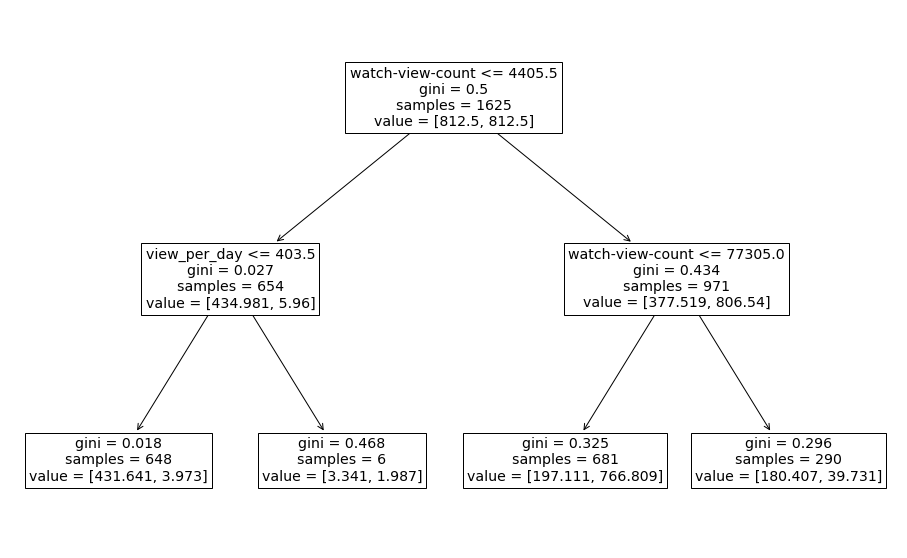

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plot_tree(model, ax=ax, feature_names=X_train.columns)

In [40]:
tfidf = TfidfVectorizer(min_df=2)
matriz_words = tfidf.fit_transform(df_filtered['watch-title'])

In [41]:
X = hstack([df_filtered[['watch-view-count', 'view_per_day']], matriz_words])
y = df_filtered[['target']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)

In [42]:
model_rfc = RandomForestClassifier(n_estimators=1000,
                                   class_weight='balanced',
                                   n_jobs=6,
                                   random_state=0)

In [43]:
model_rfc.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=6, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [44]:
predict = model_rfc.predict_proba(X_test)
print(f'AVG precision: {average_precision_score(y_test, predict[:, 1])}')
print(f'ROC AUC: {roc_auc_score(y_test, predict[:, 1])}')

AVG precision: 0.7324176111188868
ROC AUC: 0.9247625508819539


## Active Learning

Rotulamos apenas uma parte do dataset, treinamos a rede com esse dataset. Pegamos a outra parte do dataset que não foi rotulada, coloca na rede e as previsões que a rede ficar confusa (proximo a 50%) rotulamos na mão novamente, assim ganhamos o beneficio de diminuir a rotulação.

In [45]:
from skopt import forest_minimize
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from scipy.sparse import csr_matrix

In [46]:
maxAbs = MaxAbsScaler()
stdScaler = StandardScaler()
X_abs = maxAbs.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
X_abs = stdScaler.fit_transform(
    df_filtered[['watch-view-count', 'view_per_day']])
y = df_filtered[['target']]

In [53]:
def tune_forest(params):
    print(params)
    max_depth = params[0]
    n_estimators = params[1]

    min_df = params[2]
    ngram_range = (1, params[3])

    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    matriz_words = title_vec.fit_transform(df_filtered['watch-title'])

    stdScaler = StandardScaler()
    X = stdScaler.fit_transform(
        df_filtered[['watch-view-count', 'view_per_day']])
    X = hstack([X, matriz_words])
    y = df_filtered[['target']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.15,
                                                        random_state=42)

    mdl = RandomForestClassifier(max_depth=max_depth,
                                 n_estimators=n_estimators,
                                 class_weight='balanced',
                                 n_jobs=6,
                                 random_state=0)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_test)[:, 1]

    print(
        f'AVG precision: {average_precision_score(y_test, p)} - ROC AUC: {roc_auc_score(y_test, p)}'
    )

    return -average_precision_score(y_test, p)


space = [
    (1, 10),  # max_depth
    (100, 1000),  # n_estimators
    (1, 5),  # min_df
    (1, 5)
]  # ngram_range

res_forest = forest_minimize(tune_forest,
                             space,
                             random_state=160745,
                             n_random_starts=20,
                             n_calls=50,
                             verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[5, 771, 1, 3]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5688855991013047 - ROC AUC: 0.8257123473541383
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3978
Function value obtained: -0.5689
Current minimum: -0.5689
Iteration No: 2 started. Evaluating function at random point.
[8, 108, 5, 3]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7348524295416435 - ROC AUC: 0.8918249660786974
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4391
Function value obtained: -0.7349
Current minimum: -0.7349
Iteration No: 3 started. Evaluating function at random point.
[9, 101, 2, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6273189488713773 - ROC AUC: 0.8602442333785617
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3947
Function value obtained: -0.6273
Current minimum: -0.7349
Iteration No: 4 started. Evaluating function at random point.
[6, 600, 2, 3]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.569728979890268 - ROC AUC: 0.826662143826323
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1392
Function value obtained: -0.5697
Current minimum: -0.7349
Iteration No: 5 started. Evaluating function at random point.
[5, 450, 4, 4]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6547069628365184 - ROC AUC: 0.8626187245590231
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9249
Function value obtained: -0.6547
Current minimum: -0.7349
Iteration No: 6 started. Evaluating function at random point.
[7, 273, 1, 4]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.4643638884402288 - ROC AUC: 0.7628222523744912
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.7548
Function value obtained: -0.4644
Current minimum: -0.7349
Iteration No: 7 started. Evaluating function at random point.
[9, 492, 2, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7232311661428978 - ROC AUC: 0.8949796472184532
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.9403
Function value obtained: -0.7232
Current minimum: -0.7349
Iteration No: 8 started. Evaluating function at random point.
[2, 828, 5, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6136989006439245 - ROC AUC: 0.848371777476255
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 1.5019
Function value obtained: -0.6137
Current minimum: -0.7349
Iteration No: 9 started. Evaluating function at random point.
[1, 491, 3, 5]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.559336780989006 - ROC AUC: 0.818012211668928
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.9593
Function value obtained: -0.5593
Current minimum: -0.7349
Iteration No: 10 started. Evaluating function at random point.
[6, 961, 4, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7217676924004326 - ROC AUC: 0.900067842605156
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.6184
Function value obtained: -0.7218
Current minimum: -0.7349
Iteration No: 11 started. Evaluating function at random point.
[10, 800, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7742324205053588 - ROC AUC: 0.9211668928086839
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 1.4482
Function value obtained: -0.7742
Current minimum: -0.7742
Iteration No: 12 started. Evaluating function at random point.
[10, 672, 5, 4]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.740853792474186 - ROC AUC: 0.899864314789688
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 1.1804
Function value obtained: -0.7409
Current minimum: -0.7742
Iteration No: 13 started. Evaluating function at random point.
[3, 760, 3, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6662148565816639 - ROC AUC: 0.8597693351424694
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 1.2620
Function value obtained: -0.6662
Current minimum: -0.7742
Iteration No: 14 started. Evaluating function at random point.
[1, 803, 1, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5089834923920177 - ROC AUC: 0.8138738127544097
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 1.3749
Function value obtained: -0.5090
Current minimum: -0.7742
Iteration No: 15 started. Evaluating function at random point.
[1, 683, 3, 4]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5515320909087396 - ROC AUC: 0.8328018995929444
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 1.2431
Function value obtained: -0.5515
Current minimum: -0.7742
Iteration No: 16 started. Evaluating function at random point.
[8, 604, 3, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7142145261510426 - ROC AUC: 0.8905020352781547
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 1.2225
Function value obtained: -0.7142
Current minimum: -0.7742
Iteration No: 17 started. Evaluating function at random point.
[6, 732, 2, 3]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5752089400368774 - ROC AUC: 0.8277476255088195
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.2854
Function value obtained: -0.5752
Current minimum: -0.7742
Iteration No: 18 started. Evaluating function at random point.
[9, 346, 4, 5]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.67610748043007 - ROC AUC: 0.8745590230664858
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.8062
Function value obtained: -0.6761
Current minimum: -0.7742
Iteration No: 19 started. Evaluating function at random point.
[6, 790, 5, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7180475015807644 - ROC AUC: 0.9
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 1.4710
Function value obtained: -0.7180
Current minimum: -0.7742
Iteration No: 20 started. Evaluating function at random point.
[1, 449, 5, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5678726929360862 - ROC AUC: 0.8260854816824966
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 1.2934
Function value obtained: -0.5679
Current minimum: -0.7742
Iteration No: 21 started. Searching for the next optimal point.
[10, 886, 1, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6820874653517677 - ROC AUC: 0.8682496607869742
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.0134
Function value obtained: -0.6821
Current minimum: -0.7742
Iteration No: 22 started. Searching for the next optimal point.
[10, 600, 1, 2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6050915737533588 - ROC AUC: 0.8470827679782904
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.5331
Function value obtained: -0.6051
Current minimum: -0.7742
Iteration No: 23 started. Searching for the next optimal point.
[10, 831, 3, 4]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7197198684283836 - ROC AUC: 0.8936227951153325
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.0270
Function value obtained: -0.7197
Current minimum: -0.7742
Iteration No: 24 started. Searching for the next optimal point.
[10, 891, 2, 5]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6147386789951798 - ROC AUC: 0.8521031207598372
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.1515
Function value obtained: -0.6147
Current minimum: -0.7742
Iteration No: 25 started. Searching for the next optimal point.
[7, 799, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7642375937176481 - ROC AUC: 0.9168928086838535
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.8908
Function value obtained: -0.7642
Current minimum: -0.7742
Iteration No: 26 started. Searching for the next optimal point.
[7, 140, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7762468260180856 - ROC AUC: 0.9151967435549524
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8329
Function value obtained: -0.7762
Current minimum: -0.7762
Iteration No: 27 started. Searching for the next optimal point.
[4, 699, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7083582634858858 - ROC AUC: 0.8879240162822252
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.5350
Function value obtained: -0.7084
Current minimum: -0.7762
Iteration No: 28 started. Searching for the next optimal point.
[3, 734, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7074131681286197 - ROC AUC: 0.8867706919945726
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.6892
Function value obtained: -0.7074
Current minimum: -0.7762
Iteration No: 29 started. Searching for the next optimal point.
[1, 887, 5, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5865358026622918 - ROC AUC: 0.8314789687924016
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.9094
Function value obtained: -0.5865
Current minimum: -0.7762
Iteration No: 30 started. Searching for the next optimal point.
[7, 903, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7660684629375165 - ROC AUC: 0.9170284938941655
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.1256
Function value obtained: -0.7661
Current minimum: -0.7762
Iteration No: 31 started. Searching for the next optimal point.
[6, 180, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7468188203998958 - ROC AUC: 0.9042740841248303
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.8761
Function value obtained: -0.7468
Current minimum: -0.7762
Iteration No: 32 started. Searching for the next optimal point.
[10, 154, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7705442029857806 - ROC AUC: 0.9110583446404342
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.8396
Function value obtained: -0.7705
Current minimum: -0.7762
Iteration No: 33 started. Searching for the next optimal point.
[10, 144, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7609401674515326 - ROC AUC: 0.9116010854816825
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.8973
Function value obtained: -0.7609
Current minimum: -0.7762
Iteration No: 34 started. Searching for the next optimal point.
[9, 114, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7456400360822777 - ROC AUC: 0.9084803256445048
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.8240
Function value obtained: -0.7456
Current minimum: -0.7762
Iteration No: 35 started. Searching for the next optimal point.
[7, 161, 1, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.5929339429201754 - ROC AUC: 0.8332767978290366
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.8518
Function value obtained: -0.5929
Current minimum: -0.7762
Iteration No: 36 started. Searching for the next optimal point.
[7, 123, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7794557428725207 - ROC AUC: 0.917910447761194
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.8505
Function value obtained: -0.7795
Current minimum: -0.7795
Iteration No: 37 started. Searching for the next optimal point.
[7, 120, 4, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7264913078875693 - ROC AUC: 0.9117367706919945
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.8560
Function value obtained: -0.7265
Current minimum: -0.7795
Iteration No: 38 started. Searching for the next optimal point.
[7, 144, 3, 3]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6576486452046317 - ROC AUC: 0.8733378561736771
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.9149
Function value obtained: -0.6576
Current minimum: -0.7795
Iteration No: 39 started. Searching for the next optimal point.
[7, 168, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.769846849013364 - ROC AUC: 0.912618724559023
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.8563
Function value obtained: -0.7698
Current minimum: -0.7795
Iteration No: 40 started. Searching for the next optimal point.
[7, 174, 4, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7282857973460131 - ROC AUC: 0.9076662143826324
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.8748
Function value obtained: -0.7283
Current minimum: -0.7795
Iteration No: 41 started. Searching for the next optimal point.
[7, 185, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7764597500983574 - ROC AUC: 0.914246947082768
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.9361
Function value obtained: -0.7765
Current minimum: -0.7795
Iteration No: 42 started. Searching for the next optimal point.
[6, 164, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7427589762383937 - ROC AUC: 0.9024423337856173
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8489
Function value obtained: -0.7428
Current minimum: -0.7795
Iteration No: 43 started. Searching for the next optimal point.
[7, 121, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7700709674341485 - ROC AUC: 0.9147896879240163
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.8477
Function value obtained: -0.7701
Current minimum: -0.7795
Iteration No: 44 started. Searching for the next optimal point.
[5, 139, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6940285511620936 - ROC AUC: 0.8822252374491181
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8602
Function value obtained: -0.6940
Current minimum: -0.7795
Iteration No: 45 started. Searching for the next optimal point.
[7, 161, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7695764382361292 - ROC AUC: 0.9132971506105835
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.8709
Function value obtained: -0.7696
Current minimum: -0.7795
Iteration No: 46 started. Searching for the next optimal point.
[8, 154, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7690228239574081 - ROC AUC: 0.9141451831750339
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.8673
Function value obtained: -0.7690
Current minimum: -0.7795
Iteration No: 47 started. Searching for the next optimal point.
[7, 138, 2, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.6968849734772913 - ROC AUC: 0.8919606512890095
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.8454
Function value obtained: -0.6969
Current minimum: -0.7795
Iteration No: 48 started. Searching for the next optimal point.
[7, 162, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.768687805568002 - ROC AUC: 0.9139755766621438
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.8473
Function value obtained: -0.7687
Current minimum: -0.7795
Iteration No: 49 started. Searching for the next optimal point.
[7, 153, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7690759661539357 - ROC AUC: 0.9128222523744912
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.8715
Function value obtained: -0.7691
Current minimum: -0.7795
Iteration No: 50 started. Searching for the next optimal point.
[7, 165, 3, 1]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.769678240836446 - ROC AUC: 0.9135006784260515
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9265
Function value obtained: -0.7697
Current minimum: -0.7795


In [72]:
params = res_forest.x

max_depth = params[0]
n_estimators = params[1]

min_df = params[2]
ngram_range = (1, params[3])

title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
matriz_words = title_vec.fit_transform(df_filtered['watch-title'])
    
stdScaler = StandardScaler()
X = stdScaler.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
X = hstack([X, matriz_words])
y = df_filtered[['target']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)
    
model_forest = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, class_weight='balanced',
                                 n_jobs=6, random_state=0)
    
model_forest.fit(X_train, y_train)
    
predict_forest = model_forest.predict_proba(X_test)[:, 1]
    
print(f'AVG precision: {average_precision_score(y_test, predict_forest)} - ROC AUC: {roc_auc_score(y_test, predict_forest)}')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


AVG precision: 0.7794557428725207 - ROC AUC: 0.917910447761194


In [67]:
def tune_logistic(params):
    print(params)
    c = params[0]
    penalty = params[1]
    
    min_df = params[2]
    ngram_range = (1, params[3])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    matriz_words = title_vec.fit_transform(df_filtered['watch-title'])
    
    stdScaler = StandardScaler()
    X = stdScaler.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
    X = hstack([X, matriz_words])
    y = df_filtered[['target']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)
    
    mdl = LogisticRegression(C=c, class_weight='balanced', n_jobs=6, random_state=0, penalty=penalty)
    
    mdl.fit(X_train, y_train)
    
    p = mdl.predict_proba(X_test)[:, 1]
    print(f'AVG precision: {average_precision_score(y_test, p)} - ROC AUC: {roc_auc_score(y_test, p)}')
    
    return -average_precision_score(y_test, p)


space = [(0.001, 1000), # c
         ('l1', 'l2'),
          (1,5), # min_df
          (1,5)] # ngram_range

res_logistic = forest_minimize(tune_logistic, space, random_state=160745, n_random_starts=20, n_calls=200, verbose=1)


Iteration No: 1 started. Evaluating function at random point.
[498.80097587347984, 'l1', 1, 3]
AVG precision: 0.36372938708490743 - ROC AUC: 0.6670284938941655
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1916
Function value obtained: -0.3637
Current minimum: -0.3637
Iteration No: 2 started. Evaluating function at random point.
[465.92919761001815, 'l1', 1, 2]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.3702254739283236 - ROC AUC: 0.6720488466757124
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1245
Function value obtained: -0.3702
Current minimum: -0.3702
Iteration No: 3 started. Evaluating function at random point.
[73.98797112722825, 'l2', 4, 5]
AVG precision: 0.3329170876483635 - ROC AUC: 0.6279511533242876
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1703
Function value obtained: -0.3329
Current minimum: -0.3702
Iteration No: 4 started. Evaluating function at random point.
[548.5628477714339, 'l2', 4, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.31669848935712863 - ROC AUC: 0.592876526458616
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1607
Function value obtained: -0.3167
Current minimum: -0.3702
Iteration No: 5 started. Evaluating function at random point.
[861.2712022890199, 'l2', 4, 3]
AVG precision: 0.3054185468350371 - ROC AUC: 0.5883310719131615
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1225
Function value obtained: -0.3054
Current minimum: -0.3702
Iteration No: 6 started. Evaluating function at random point.
[74.60938538423518, 'l1', 2, 1]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.35510863282282223 - ROC AUC: 0.6194708276797829
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0873
Function value obtained: -0.3551
Current minimum: -0.3702
Iteration No: 7 started. Evaluating function at random point.
[670.1277566291132, 'l1', 5, 2]
AVG precision: 0.31219399436089235 - ROC AUC: 0.5980325644504748
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.7471
Function value obtained: -0.3122
Current minimum: -0.3702
Iteration No: 8 started. Evaluating function at random point.
[965.4887607290873, 'l2', 5, 3]
AVG precision: 0.3101360365078235 - ROC AUC: 0.6007462686567164
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.1189
Function value obtained: -0.3101
Current minimum: -0.3702
Iteration No: 9 started. Evaluating function at random point.
[85.66044530909893, 'l1', 4, 1]
AVG precision: 0.30351180301399444 - ROC AUC: 0.6184531886024422
Iteration No: 9 ended. Evaluation done at random point.
Time

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.3542058200405942 - ROC AUC: 0.6181818181818182
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.2715
Function value obtained: -0.3542
Current minimum: -0.3702
Iteration No: 11 started. Evaluating function at random point.
[16.769121724580142, 'l2', 5, 5]
AVG precision: 0.3444148838355644 - ROC AUC: 0.6529850746268656
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.1520
Function value obtained: -0.3444
Current minimum: -0.3702
Iteration No: 12 started. Evaluating function at random point.
[179.74955299653243, 'l2', 5, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.32626488149857097 - ROC AUC: 0.6167571234735415
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.1093
Function value obtained: -0.3263
Current minimum: -0.3702
Iteration No: 13 started. Evaluating function at random point.
[241.78291622300338, 'l1', 1, 2]
AVG precision: 0.37043549947864685 - ROC AUC: 0.6694029850746268
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.1124
Function value obtained: -0.3704
Current minimum: -0.3704
Iteration No: 14 started. Evaluating function at random point.
[91.108012830608, 'l1', 4, 1]
AVG precision: 0.3025274713887936 - ROC AUC: 0.6165535956580733
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.0712
Function value obtained: -0.3025
Current minimum: -0.3704
Iteration No: 15 started. Evaluating function at random point.
[367.7388466201667, 'l1', 5, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.2936994671050216 - ROC AUC: 0.5844301221166893
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.4628
Function value obtained: -0.2937
Current minimum: -0.3704
Iteration No: 16 started. Evaluating function at random point.
[988.2332353728526, 'l2', 3, 4]
AVG precision: 0.32484657077432877 - ROC AUC: 0.605563093622795
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.1531
Function value obtained: -0.3248
Current minimum: -0.3704
Iteration No: 17 started. Evaluating function at random point.
[655.6507969899259, 'l2', 5, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.3095802780989875 - ROC AUC: 0.6028493894165535
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.1235
Function value obtained: -0.3096
Current minimum: -0.3704
Iteration No: 18 started. Evaluating function at random point.
[651.5854231583742, 'l1', 2, 1]
AVG precision: 0.330204073419612 - ROC AUC: 0.5879579375848033
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.1865
Function value obtained: -0.3302
Current minimum: -0.3704
Iteration No: 19 started. Evaluating function at random point.
[612.9579405315293, 'l2', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

AVG precision: 0.3869318074791487 - ROC AUC: 0.6748303934871098
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.1803
Function value obtained: -0.3869
Current minimum: -0.3869
Iteration No: 20 started. Evaluating function at random point.
[362.71049786530364, 'l1', 4, 4]
AVG precision: 0.27018793748918735 - ROC AUC: 0.5688602442333786
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.7741
Function value obtained: -0.2702
Current minimum: -0.3869
Iteration No: 21 started. Searching for the next optimal point.
[631.8609771833967, 'l1', 2, 4]
AVG precision: 0.42195912019819015 - ROC AUC: 0.6806648575305291


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5239
Function value obtained: -0.4220
Current minimum: -0.4220
Iteration No: 22 started. Searching for the next optimal point.
[812.9662888602005, 'l2', 2, 4]
AVG precision: 0.39316224590447396 - ROC AUC: 0.6743554952510177


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4758
Function value obtained: -0.3932
Current minimum: -0.4220
Iteration No: 23 started. Searching for the next optimal point.
[636.2097093054006, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4239882367083888 - ROC AUC: 0.6812075983717775
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5480
Function value obtained: -0.4240
Current minimum: -0.4240
Iteration No: 24 started. Searching for the next optimal point.
[966.4094502119888, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4088258785428651 - ROC AUC: 0.6760515603799186
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5584
Function value obtained: -0.4088
Current minimum: -0.4240
Iteration No: 25 started. Searching for the next optimal point.
[997.8826855539633, 'l1', 3, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.3217158454667257 - ROC AUC: 0.5863636363636364
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7185
Function value obtained: -0.3217
Current minimum: -0.4240
Iteration No: 26 started. Searching for the next optimal point.
[740.7236718010084, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4184109967893808 - ROC AUC: 0.6798507462686567
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5584
Function value obtained: -0.4184
Current minimum: -0.4240
Iteration No: 27 started. Searching for the next optimal point.
[994.8063941505845, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.40789992649261286 - ROC AUC: 0.6750339213025781
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5536
Function value obtained: -0.4079
Current minimum: -0.4240
Iteration No: 28 started. Searching for the next optimal point.
[649.7991740567187, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.41828876193365594 - ROC AUC: 0.6778833107191315
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5804
Function value obtained: -0.4183
Current minimum: -0.4240
Iteration No: 29 started. Searching for the next optimal point.
[584.3936609490627, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4240188440987942 - ROC AUC: 0.6792401628222523
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5345
Function value obtained: -0.4240
Current minimum: -0.4240
Iteration No: 30 started. Searching for the next optimal point.
[584.8924886406253, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42492265129524615 - ROC AUC: 0.6800542740841248
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5336
Function value obtained: -0.4249
Current minimum: -0.4249
Iteration No: 31 started. Searching for the next optimal point.
[283.13533249575295, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42124653632787984 - ROC AUC: 0.674966078697422
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.5329
Function value obtained: -0.4212
Current minimum: -0.4249
Iteration No: 32 started. Searching for the next optimal point.
[527.416921438456, 'l1', 2, 4]
AVG precision: 0.4281986288940378 - ROC AUC: 0.6808005427408413


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.5077
Function value obtained: -0.4282
Current minimum: -0.4282
Iteration No: 33 started. Searching for the next optimal point.
[442.8130987379365, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4247186446274338 - ROC AUC: 0.6791044776119401
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.5857
Function value obtained: -0.4247
Current minimum: -0.4282
Iteration No: 34 started. Searching for the next optimal point.
[378.97436642475856, 'l1', 2, 4]
AVG precision: 0.42633752011553294 - ROC AUC: 0.676865671641791


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.5091
Function value obtained: -0.4263
Current minimum: -0.4282
Iteration No: 35 started. Searching for the next optimal point.
[383.7088006162781, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4275308843945699 - ROC AUC: 0.67876526458616
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.5382
Function value obtained: -0.4275
Current minimum: -0.4282
Iteration No: 36 started. Searching for the next optimal point.
[353.57150200613495, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42547096183168626 - ROC AUC: 0.6765264586160109
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.5532
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 37 started. Searching for the next optimal point.
[360.15181152560314, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42589578280897195 - ROC AUC: 0.6778154681139755
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.5513
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 38 started. Searching for the next optimal point.
[345.8703915438146, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4233823269658664 - ROC AUC: 0.6757801899592945
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.5412
Function value obtained: -0.4234
Current minimum: -0.4282
Iteration No: 39 started. Searching for the next optimal point.
[373.16539642954234, 'l2', 2, 4]
AVG precision: 0.3927217805298155 - ROC AUC: 0.6765943012211669


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.4630
Function value obtained: -0.3927
Current minimum: -0.4282
Iteration No: 40 started. Searching for the next optimal point.
[367.16478471353173, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4243962336673419 - ROC AUC: 0.6780189959294437
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.5683
Function value obtained: -0.4244
Current minimum: -0.4282
Iteration No: 41 started. Searching for the next optimal point.
[367.178560232087, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4266707122509107 - ROC AUC: 0.678493894165536
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.5489
Function value obtained: -0.4267
Current minimum: -0.4282
Iteration No: 42 started. Searching for the next optimal point.
[112.24310112806627, 'l1', 2, 4]
AVG precision: 0.41385025089782923 - ROC AUC: 0.6757801899592945


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.5099
Function value obtained: -0.4139
Current minimum: -0.4282
Iteration No: 43 started. Searching for the next optimal point.
[983.2924724659448, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4052597664681556 - ROC AUC: 0.6753731343283582
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.5893
Function value obtained: -0.4053
Current minimum: -0.4282
Iteration No: 44 started. Searching for the next optimal point.
[365.55254122541834, 'l1', 2, 3]
AVG precision: 0.4161606081412662 - ROC AUC: 0.6803934871099051


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.5708
Function value obtained: -0.4162
Current minimum: -0.4282
Iteration No: 45 started. Searching for the next optimal point.
[387.8107881656655, 'l1', 2, 3]
AVG precision: 0.4167224580961859 - ROC AUC: 0.6814789687924017


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.5311
Function value obtained: -0.4167
Current minimum: -0.4282
Iteration No: 46 started. Searching for the next optimal point.
[41.577030741597376, 'l1', 2, 4]
AVG precision: 0.4123340081608511 - ROC AUC: 0.6767299864314789


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.5146
Function value obtained: -0.4123
Current minimum: -0.4282
Iteration No: 47 started. Searching for the next optimal point.
[353.364935112004, 'l1', 2, 3]
AVG precision: 0.41652652065733664 - ROC AUC: 0.6806648575305292


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.5141
Function value obtained: -0.4165
Current minimum: -0.4282
Iteration No: 48 started. Searching for the next optimal point.
[647.2912893673906, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.41958096152321245 - ROC AUC: 0.678697421981004
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.5861
Function value obtained: -0.4196
Current minimum: -0.4282
Iteration No: 49 started. Searching for the next optimal point.
[87.32307337485037, 'l1', 2, 4]
AVG precision: 0.41486716710879135 - ROC AUC: 0.675101763907734


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.5350
Function value obtained: -0.4149
Current minimum: -0.4282
Iteration No: 50 started. Searching for the next optimal point.
[375.67359015635196, 'l1', 1, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.36824213993095484 - ROC AUC: 0.6581411126187245
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.5727
Function value obtained: -0.3682
Current minimum: -0.4282
Iteration No: 51 started. Searching for the next optimal point.
[369.89360022668586, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42606839689176135 - ROC AUC: 0.6777476255088196
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.5467
Function value obtained: -0.4261
Current minimum: -0.4282
Iteration No: 52 started. Searching for the next optimal point.
[377.18343643186273, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4266855721873261 - ROC AUC: 0.6788331071913162
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.6138
Function value obtained: -0.4267
Current minimum: -0.4282
Iteration No: 53 started. Searching for the next optimal point.
[372.1509322216003, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4272937377542259 - ROC AUC: 0.6787652645861602
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.5644
Function value obtained: -0.4273
Current minimum: -0.4282
Iteration No: 54 started. Searching for the next optimal point.
[377.2205040857361, 'l1', 2, 4]
AVG precision: 0.42727006254769184 - ROC AUC: 0.6780189959294437


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.5484
Function value obtained: -0.4273
Current minimum: -0.4282
Iteration No: 55 started. Searching for the next optimal point.
[379.3935734506987, 'l1', 2, 4]
AVG precision: 0.42697568103857286 - ROC AUC: 0.6779511533242876


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.5306
Function value obtained: -0.4270
Current minimum: -0.4282
Iteration No: 56 started. Searching for the next optimal point.
[371.6735306739364, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4266041587037616 - ROC AUC: 0.6778154681139755
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.5596
Function value obtained: -0.4266
Current minimum: -0.4282
Iteration No: 57 started. Searching for the next optimal point.
[375.534420718882, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4267500449864424 - ROC AUC: 0.6782903663500678
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.5550
Function value obtained: -0.4268
Current minimum: -0.4282
Iteration No: 58 started. Searching for the next optimal point.
[364.28409388383363, 'l1', 1, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.36848082544885097 - ROC AUC: 0.6579375848032564
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.5767
Function value obtained: -0.3685
Current minimum: -0.4282
Iteration No: 59 started. Searching for the next optimal point.
[603.5517611627162, 'l1', 2, 3]
AVG precision: 0.420384059436367 - ROC AUC: 0.6827001356852104


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 0.5258
Function value obtained: -0.4204
Current minimum: -0.4282
Iteration No: 60 started. Searching for the next optimal point.
[656.5190545970377, 'l1', 2, 3]
AVG precision: 0.41902952815767125 - ROC AUC: 0.6824287652645862


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.5203
Function value obtained: -0.4190
Current minimum: -0.4282
Iteration No: 61 started. Searching for the next optimal point.
[648.6455034688262, 'l1', 2, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4164305131870464 - ROC AUC: 0.6813432835820895
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.6289
Function value obtained: -0.4164
Current minimum: -0.4282
Iteration No: 62 started. Searching for the next optimal point.
[649.537008350226, 'l1', 2, 3]
AVG precision: 0.4166637605530088 - ROC AUC: 0.6818181818181819


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 0.5401
Function value obtained: -0.4167
Current minimum: -0.4282
Iteration No: 63 started. Searching for the next optimal point.
[653.973904158854, 'l1', 2, 3]
AVG precision: 0.4184466244260579 - ROC AUC: 0.6816146540027137


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 0.5414
Function value obtained: -0.4184
Current minimum: -0.4282
Iteration No: 64 started. Searching for the next optimal point.
[658.2718818039993, 'l1', 2, 3]
AVG precision: 0.4192910590665723 - ROC AUC: 0.6824966078697423


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.5337
Function value obtained: -0.4193
Current minimum: -0.4282
Iteration No: 65 started. Searching for the next optimal point.
[376.87844015667594, 'l1', 2, 1]
AVG precision: 0.3420981825309518 - ROC AUC: 0.5924016282225236


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 0.4897
Function value obtained: -0.3421
Current minimum: -0.4282
Iteration No: 66 started. Searching for the next optimal point.
[360.5747697144576, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4264410537367627 - ROC AUC: 0.6777476255088195
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 0.5584
Function value obtained: -0.4264
Current minimum: -0.4282
Iteration No: 67 started. Searching for the next optimal point.
[382.9474280710251, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.423594878027101 - ROC AUC: 0.6782225237449119
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 0.5683
Function value obtained: -0.4236
Current minimum: -0.4282
Iteration No: 68 started. Searching for the next optimal point.
[363.74210821520734, 'l1', 2, 4]
AVG precision: 0.4249935435292931 - ROC AUC: 0.6768656716417911


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 0.5401
Function value obtained: -0.4250
Current minimum: -0.4282
Iteration No: 69 started. Searching for the next optimal point.
[358.7212764722747, 'l1', 2, 4]
AVG precision: 0.4255232970174782 - ROC AUC: 0.6778154681139756


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 0.5363
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 70 started. Searching for the next optimal point.
[594.7869579207695, 'l1', 2, 2]
AVG precision: 0.4041617966073377 - ROC AUC: 0.6534599728629579


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 0.4805
Function value obtained: -0.4042
Current minimum: -0.4282
Iteration No: 71 started. Searching for the next optimal point.
[647.6069594096209, 'l1', 2, 2]
AVG precision: 0.40547691823179965 - ROC AUC: 0.6537313432835821


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 0.5405
Function value obtained: -0.4055
Current minimum: -0.4282
Iteration No: 72 started. Searching for the next optimal point.
[368.4959540521349, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42582820870509813 - ROC AUC: 0.6774084124830394
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 0.5407
Function value obtained: -0.4258
Current minimum: -0.4282
Iteration No: 73 started. Searching for the next optimal point.
[448.1076534923281, 'l1', 2, 2]
AVG precision: 0.4055462928604676 - ROC AUC: 0.6542062415196744


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 0.4628
Function value obtained: -0.4055
Current minimum: -0.4282
Iteration No: 74 started. Searching for the next optimal point.
[358.6388748036239, 'l1', 2, 4]
AVG precision: 0.4265013570217677 - ROC AUC: 0.6782225237449118


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 0.5236
Function value obtained: -0.4265
Current minimum: -0.4282
Iteration No: 75 started. Searching for the next optimal point.
[378.7314085142362, 'l1', 2, 4]
AVG precision: 0.42554861131197813 - ROC AUC: 0.6774084124830393


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 0.5249
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 76 started. Searching for the next optimal point.
[384.18002927226854, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42640986738056574 - ROC AUC: 0.6782225237449119
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 0.5686
Function value obtained: -0.4264
Current minimum: -0.4282
Iteration No: 77 started. Searching for the next optimal point.
[372.0782787520401, 'l1', 2, 4]
AVG precision: 0.4258729020169303 - ROC AUC: 0.6780189959294437


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 0.5267
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 78 started. Searching for the next optimal point.
[917.2183738019462, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4126972076025486 - ROC AUC: 0.6753731343283582
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 0.6279
Function value obtained: -0.4127
Current minimum: -0.4282
Iteration No: 79 started. Searching for the next optimal point.
[376.7562048081003, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42597508407824847 - ROC AUC: 0.6777476255088195
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 0.5800
Function value obtained: -0.4260
Current minimum: -0.4282
Iteration No: 80 started. Searching for the next optimal point.
[999.107982673882, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.40436452922247657 - ROC AUC: 0.6748303934871098
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 0.6746
Function value obtained: -0.4044
Current minimum: -0.4282
Iteration No: 81 started. Searching for the next optimal point.
[384.89329520126336, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4259050500935859 - ROC AUC: 0.6779511533242876
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 0.5753
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 82 started. Searching for the next optimal point.
[377.2730679328271, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4272275595422378 - ROC AUC: 0.6780868385345997
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 0.5612
Function value obtained: -0.4272
Current minimum: -0.4282
Iteration No: 83 started. Searching for the next optimal point.
[387.9595647448573, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42756270943128943 - ROC AUC: 0.6780189959294437
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 0.6322
Function value obtained: -0.4276
Current minimum: -0.4282
Iteration No: 84 started. Searching for the next optimal point.
[385.09688751632336, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42781424502795096 - ROC AUC: 0.6792401628222523
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 0.5699
Function value obtained: -0.4278
Current minimum: -0.4282
Iteration No: 85 started. Searching for the next optimal point.
[390.7907780462591, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4264075698237242 - ROC AUC: 0.6781546811397559
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 0.5634
Function value obtained: -0.4264
Current minimum: -0.4282
Iteration No: 86 started. Searching for the next optimal point.
[367.77889052206257, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4254110783015951 - ROC AUC: 0.676933514246947
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 0.5587
Function value obtained: -0.4254
Current minimum: -0.4282
Iteration No: 87 started. Searching for the next optimal point.
[362.1294303379748, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4244162099930382 - ROC AUC: 0.6769335142469471
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 0.5725
Function value obtained: -0.4244
Current minimum: -0.4282
Iteration No: 88 started. Searching for the next optimal point.
[730.2150778202551, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4140457682989256 - ROC AUC: 0.6771370420624152
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 0.6191
Function value obtained: -0.4140
Current minimum: -0.4282
Iteration No: 89 started. Searching for the next optimal point.
[371.6064626777173, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4256074385700447 - ROC AUC: 0.676662143826323
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 0.5699
Function value obtained: -0.4256
Current minimum: -0.4282
Iteration No: 90 started. Searching for the next optimal point.
[365.08899408999787, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4258548774548843 - ROC AUC: 0.6772048846675712
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 0.5662
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 91 started. Searching for the next optimal point.
[362.0660917139788, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4255925719815875 - ROC AUC: 0.6780189959294437
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 0.6404
Function value obtained: -0.4256
Current minimum: -0.4282
Iteration No: 92 started. Searching for the next optimal point.
[366.95393251474667, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42690932064534065 - ROC AUC: 0.6783582089552239
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 0.5734
Function value obtained: -0.4269
Current minimum: -0.4282
Iteration No: 93 started. Searching for the next optimal point.
[367.1061957249209, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4265439532219798 - ROC AUC: 0.6780189959294436
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 0.5669
Function value obtained: -0.4265
Current minimum: -0.4282
Iteration No: 94 started. Searching for the next optimal point.
[366.8604351633323, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4247340127304532 - ROC AUC: 0.6776797829036636
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 0.5602
Function value obtained: -0.4247
Current minimum: -0.4282
Iteration No: 95 started. Searching for the next optimal point.
[362.4110485405558, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4256114255443612 - ROC AUC: 0.6771370420624152
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 0.5690
Function value obtained: -0.4256
Current minimum: -0.4282
Iteration No: 96 started. Searching for the next optimal point.
[365.0137229173668, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42527059332488293 - ROC AUC: 0.6774762550881954
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 0.5615
Function value obtained: -0.4253
Current minimum: -0.4282
Iteration No: 97 started. Searching for the next optimal point.
[366.4735178811569, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4254422570157125 - ROC AUC: 0.6770013568521032
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 0.5700
Function value obtained: -0.4254
Current minimum: -0.4282
Iteration No: 98 started. Searching for the next optimal point.
[363.3552846398437, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42667503540703716 - ROC AUC: 0.6778833107191317
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 0.5616
Function value obtained: -0.4267
Current minimum: -0.4282
Iteration No: 99 started. Searching for the next optimal point.
[362.1952775404652, 'l1', 2, 3]
AVG precision: 0.4169459014125465 - ROC AUC: 0.6811397557666216


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 0.5261
Function value obtained: -0.4169
Current minimum: -0.4282
Iteration No: 100 started. Searching for the next optimal point.
[369.3529830537336, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4262578355530803 - ROC AUC: 0.6776797829036635
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 0.6398
Function value obtained: -0.4263
Current minimum: -0.4282
Iteration No: 101 started. Searching for the next optimal point.
[370.1388712389312, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4262370512576765 - ROC AUC: 0.6779511533242876
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 0.5607
Function value obtained: -0.4262
Current minimum: -0.4282
Iteration No: 102 started. Searching for the next optimal point.
[362.75789645243583, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42623178423243935 - ROC AUC: 0.6775440976933514
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 0.5685
Function value obtained: -0.4262
Current minimum: -0.4282
Iteration No: 103 started. Searching for the next optimal point.
[362.11866719349166, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42545915737959805 - ROC AUC: 0.6772727272727272
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 0.5611
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 104 started. Searching for the next optimal point.
[956.7070549090356, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4083830959743846 - ROC AUC: 0.6761194029850746
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 0.5812
Function value obtained: -0.4084
Current minimum: -0.4282
Iteration No: 105 started. Searching for the next optimal point.
[987.3889501737572, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.40624615583283663 - ROC AUC: 0.6752374491180461
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 0.6128
Function value obtained: -0.4062
Current minimum: -0.4282
Iteration No: 106 started. Searching for the next optimal point.
[383.957189605581, 'l1', 3, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.33093805389474895 - ROC AUC: 0.5957937584803257
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 0.6078
Function value obtained: -0.3309
Current minimum: -0.4282
Iteration No: 107 started. Searching for the next optimal point.
[396.6013654357442, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42554095357567867 - ROC AUC: 0.677001356852103
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 0.5716
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 108 started. Searching for the next optimal point.
[383.6918357279404, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42761882268161155 - ROC AUC: 0.6787652645861602
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 0.5564
Function value obtained: -0.4276
Current minimum: -0.4282
Iteration No: 109 started. Searching for the next optimal point.
[365.1719172950836, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42449826631745313 - ROC AUC: 0.6768656716417911
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 0.5584
Function value obtained: -0.4245
Current minimum: -0.4282
Iteration No: 110 started. Searching for the next optimal point.
[385.8577491101478, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4258939015738923 - ROC AUC: 0.6777476255088195
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 0.6345
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 111 started. Searching for the next optimal point.
[362.7680611571866, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42570636559595815 - ROC AUC: 0.6772727272727272
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 0.5587
Function value obtained: -0.4257
Current minimum: -0.4282
Iteration No: 112 started. Searching for the next optimal point.
[364.41398710828616, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4245218192171058 - ROC AUC: 0.6764586160108548
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 0.5782
Function value obtained: -0.4245
Current minimum: -0.4282
Iteration No: 113 started. Searching for the next optimal point.
[384.5575011670343, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4272850499937726 - ROC AUC: 0.6782903663500678
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 0.5542
Function value obtained: -0.4273
Current minimum: -0.4282
Iteration No: 114 started. Searching for the next optimal point.
[360.3215499156509, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42505564491332576 - ROC AUC: 0.6770691994572592
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 0.5568
Function value obtained: -0.4251
Current minimum: -0.4282
Iteration No: 115 started. Searching for the next optimal point.
[382.0439859182958, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42627784381679723 - ROC AUC: 0.6779511533242877
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 0.5663
Function value obtained: -0.4263
Current minimum: -0.4282
Iteration No: 116 started. Searching for the next optimal point.
[384.04001651498527, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4252485825482986 - ROC AUC: 0.6779511533242876
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 0.5649
Function value obtained: -0.4252
Current minimum: -0.4282
Iteration No: 117 started. Searching for the next optimal point.
[359.4776883715022, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42432745435909075 - ROC AUC: 0.6765264586160109
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 0.5544
Function value obtained: -0.4243
Current minimum: -0.4282
Iteration No: 118 started. Searching for the next optimal point.
[381.6918811012127, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4262271196983571 - ROC AUC: 0.6768656716417911
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 0.5746
Function value obtained: -0.4262
Current minimum: -0.4282
Iteration No: 119 started. Searching for the next optimal point.
[362.09430419652597, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42452677681969375 - ROC AUC: 0.6772727272727272
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 0.5644
Function value obtained: -0.4245
Current minimum: -0.4282
Iteration No: 120 started. Searching for the next optimal point.
[363.4674089596233, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4258647935789588 - ROC AUC: 0.6778833107191315
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 0.5600
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 121 started. Searching for the next optimal point.
[216.45110273281924, 'l1', 2, 2]
AVG precision: 0.40615036083058387 - ROC AUC: 0.6578018995929444


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 0.4749
Function value obtained: -0.4062
Current minimum: -0.4282
Iteration No: 122 started. Searching for the next optimal point.
[362.99057697295217, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4254569533752093 - ROC AUC: 0.6776797829036635
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 0.6374
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 123 started. Searching for the next optimal point.
[363.0359069410993, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42549918806788767 - ROC AUC: 0.6777476255088195
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 0.5789
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 124 started. Searching for the next optimal point.
[412.4730877215318, 'l2', 2, 2]
AVG precision: 0.41158899980400776 - ROC AUC: 0.6664857530529171


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 0.4204
Function value obtained: -0.4116
Current minimum: -0.4282
Iteration No: 125 started. Searching for the next optimal point.
[341.8277517729932, 'l1', 2, 3]
AVG precision: 0.4165610425496355 - ROC AUC: 0.6805970149253732


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 0.5212
Function value obtained: -0.4166
Current minimum: -0.4282
Iteration No: 126 started. Searching for the next optimal point.
[362.70860338080234, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42433257086622495 - ROC AUC: 0.6770691994572592
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 0.5683
Function value obtained: -0.4243
Current minimum: -0.4282
Iteration No: 127 started. Searching for the next optimal point.
[714.1221227874464, 'l1', 2, 2]
AVG precision: 0.40544019400215425 - ROC AUC: 0.6533921302578019


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 0.5062
Function value obtained: -0.4054
Current minimum: -0.4282
Iteration No: 128 started. Searching for the next optimal point.
[354.9684362651911, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4249187367919427 - ROC AUC: 0.6763229308005427
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 0.5651
Function value obtained: -0.4249
Current minimum: -0.4282
Iteration No: 129 started. Searching for the next optimal point.
[357.5112218174034, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42574119445443503 - ROC AUC: 0.6772048846675712
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 0.5560
Function value obtained: -0.4257
Current minimum: -0.4282
Iteration No: 130 started. Searching for the next optimal point.
[359.77093896727376, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4254783851612037 - ROC AUC: 0.676797829036635
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 0.5645
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 131 started. Searching for the next optimal point.
[358.95547240112995, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42429029083241776 - ROC AUC: 0.6776797829036634
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 0.5637
Function value obtained: -0.4243
Current minimum: -0.4282
Iteration No: 132 started. Searching for the next optimal point.
[359.9518842388907, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4249858948735749 - ROC AUC: 0.6774084124830393
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 0.5641
Function value obtained: -0.4250
Current minimum: -0.4282
Iteration No: 133 started. Searching for the next optimal point.
[364.353079120924, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4257134987377668 - ROC AUC: 0.6776119402985075
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 0.5649
Function value obtained: -0.4257
Current minimum: -0.4282
Iteration No: 134 started. Searching for the next optimal point.
[241.56764437131508, 'l2', 2, 2]
AVG precision: 0.40719685497730795 - ROC AUC: 0.6689280868385347


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 0.4361
Function value obtained: -0.4072
Current minimum: -0.4282
Iteration No: 135 started. Searching for the next optimal point.
[687.6619866701639, 'l2', 2, 2]
AVG precision: 0.40982364932971027 - ROC AUC: 0.6651967435549526


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 0.5109
Function value obtained: -0.4098
Current minimum: -0.4282
Iteration No: 136 started. Searching for the next optimal point.
[86.00285295092053, 'l2', 2, 1]
AVG precision: 0.37240401503404885 - ROC AUC: 0.6630257801899594


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 0.3874
Function value obtained: -0.3724
Current minimum: -0.4282
Iteration No: 137 started. Searching for the next optimal point.
[449.2855550432716, 'l2', 2, 1]
AVG precision: 0.36030951874223915 - ROC AUC: 0.6421302578018996


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 0.4005
Function value obtained: -0.3603
Current minimum: -0.4282
Iteration No: 138 started. Searching for the next optimal point.
[359.42644138465414, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42444500546149533 - ROC AUC: 0.676662143826323
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 0.5544
Function value obtained: -0.4244
Current minimum: -0.4282
Iteration No: 139 started. Searching for the next optimal point.
[364.73995002190736, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4259515499738089 - ROC AUC: 0.6774762550881954
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 0.5661
Function value obtained: -0.4260
Current minimum: -0.4282
Iteration No: 140 started. Searching for the next optimal point.
[378.2614920330722, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42734028423984327 - ROC AUC: 0.6784260515603799
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 0.5738
Function value obtained: -0.4273
Current minimum: -0.4282
Iteration No: 141 started. Searching for the next optimal point.
[376.26011685784135, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42757665376596743 - ROC AUC: 0.678697421981004
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 0.5659
Function value obtained: -0.4276
Current minimum: -0.4282
Iteration No: 142 started. Searching for the next optimal point.
[373.83973551201973, 'l1', 2, 4]
AVG precision: 0.4267217546137798 - ROC AUC: 0.6779511533242877


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 0.5553
Function value obtained: -0.4267
Current minimum: -0.4282
Iteration No: 143 started. Searching for the next optimal point.
[383.69449398599363, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42761882268161155 - ROC AUC: 0.6787652645861602
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 0.6211
Function value obtained: -0.4276
Current minimum: -0.4282
Iteration No: 144 started. Searching for the next optimal point.
[379.43262716557155, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4267887059635633 - ROC AUC: 0.6774762550881954
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 0.5622
Function value obtained: -0.4268
Current minimum: -0.4282
Iteration No: 145 started. Searching for the next optimal point.
[364.12797568963254, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42686339097374904 - ROC AUC: 0.6788331071913162
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 0.5648
Function value obtained: -0.4269
Current minimum: -0.4282
Iteration No: 146 started. Searching for the next optimal point.
[377.6085735554384, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4273550606165809 - ROC AUC: 0.6778154681139755
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 0.5669
Function value obtained: -0.4274
Current minimum: -0.4282
Iteration No: 147 started. Searching for the next optimal point.
[367.81467418299496, 'l1', 2, 4]
AVG precision: 0.42596143905134465 - ROC AUC: 0.6776119402985075


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 0.5604
Function value obtained: -0.4260
Current minimum: -0.4282
Iteration No: 148 started. Searching for the next optimal point.
[383.9971519722403, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42497247896669854 - ROC AUC: 0.6777476255088195
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 0.5664
Function value obtained: -0.4250
Current minimum: -0.4282
Iteration No: 149 started. Searching for the next optimal point.
[377.55197530325046, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4266473367225048 - ROC AUC: 0.6780868385345997
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 0.5627
Function value obtained: -0.4266
Current minimum: -0.4282
Iteration No: 150 started. Searching for the next optimal point.
[968.258321244337, 'l2', 2, 3]
AVG precision: 0.39716106281660435 - ROC AUC: 0.6675033921302579


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 0.4575
Function value obtained: -0.3972
Current minimum: -0.4282
Iteration No: 151 started. Searching for the next optimal point.
[368.04930200597266, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4243277698807436 - ROC AUC: 0.676797829036635
Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 0.5738
Function value obtained: -0.4243
Current minimum: -0.4282
Iteration No: 152 started. Searching for the next optimal point.
[363.2426894585822, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42528315101789005 - ROC AUC: 0.6764586160108548
Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 0.5587
Function value obtained: -0.4253
Current minimum: -0.4282
Iteration No: 153 started. Searching for the next optimal point.
[387.06885781297456, 'l1', 1, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.3676604900168776 - ROC AUC: 0.6575305291723201
Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 0.6483
Function value obtained: -0.3677
Current minimum: -0.4282
Iteration No: 154 started. Searching for the next optimal point.
[234.5943868660557, 'l1', 2, 3]
AVG precision: 0.40292402153322815 - ROC AUC: 0.6807327001356853


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 0.5153
Function value obtained: -0.4029
Current minimum: -0.4282
Iteration No: 155 started. Searching for the next optimal point.
[911.2491196603642, 'l2', 2, 2]
AVG precision: 0.41099821771645906 - ROC AUC: 0.6645861601085482


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 0.4262
Function value obtained: -0.4110
Current minimum: -0.4282
Iteration No: 156 started. Searching for the next optimal point.
[16.098598716210624, 'l1', 2, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AVG precision: 0.4148612472692105 - ROC AUC: 0.6852781546811397
Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 4.4710
Function value obtained: -0.4149
Current minimum: -0.4282
Iteration No: 157 started. Searching for the next optimal point.
[882.9711013846344, 'l2', 2, 2]
AVG precision: 0.41007639543495544 - ROC AUC: 0.6648575305291723


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 0.4273
Function value obtained: -0.4101
Current minimum: -0.4282
Iteration No: 158 started. Searching for the next optimal point.
[362.84127923360523, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4259497883913549 - ROC AUC: 0.6773405698778833
Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 0.5737
Function value obtained: -0.4259
Current minimum: -0.4282
Iteration No: 159 started. Searching for the next optimal point.
[191.1619022708558, 'l1', 2, 3]
AVG precision: 0.40349360944155 - ROC AUC: 0.6795793758480325


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 0.5107
Function value obtained: -0.4035
Current minimum: -0.4282
Iteration No: 160 started. Searching for the next optimal point.
[362.85678126809984, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4271943216021539 - ROC AUC: 0.6781546811397557
Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 0.5794
Function value obtained: -0.4272
Current minimum: -0.4282
Iteration No: 161 started. Searching for the next optimal point.
[909.6164091614231, 'l2', 1, 2]
AVG precision: 0.3732851549103736 - ROC AUC: 0.6736770691994572


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 0.4475
Function value obtained: -0.3733
Current minimum: -0.4282
Iteration No: 162 started. Searching for the next optimal point.
[910.2985276225311, 'l2', 2, 3]
AVG precision: 0.3987094614890696 - ROC AUC: 0.6680461329715061


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 0.5359
Function value obtained: -0.3987
Current minimum: -0.4282
Iteration No: 163 started. Searching for the next optimal point.
[903.2826465688931, 'l2', 2, 3]
AVG precision: 0.3982320411259177 - ROC AUC: 0.667842605156038


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 0.4633
Function value obtained: -0.3982
Current minimum: -0.4282
Iteration No: 164 started. Searching for the next optimal point.
[14.379574282554728, 'l2', 2, 2]
AVG precision: 0.41837172102010856 - ROC AUC: 0.6991180461329715


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 0.4196
Function value obtained: -0.4184
Current minimum: -0.4282
Iteration No: 165 started. Searching for the next optimal point.
[967.2367454555094, 'l2', 2, 2]
AVG precision: 0.41109688076872003 - ROC AUC: 0.664111261872456


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 0.4290
Function value obtained: -0.4111
Current minimum: -0.4282
Iteration No: 166 started. Searching for the next optimal point.
[362.9616440452508, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42701647691457967 - ROC AUC: 0.6783582089552239
Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 0.5778
Function value obtained: -0.4270
Current minimum: -0.4282
Iteration No: 167 started. Searching for the next optimal point.
[140.88196591026468, 'l2', 2, 2]
AVG precision: 0.4092679487586203 - ROC AUC: 0.6727272727272726


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 0.4235
Function value obtained: -0.4093
Current minimum: -0.4282
Iteration No: 168 started. Searching for the next optimal point.
[383.85360123572394, 'l2', 3, 2]
AVG precision: 0.37986585984452736 - ROC AUC: 0.6350746268656716


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 0.4299
Function value obtained: -0.3799
Current minimum: -0.4282
Iteration No: 169 started. Searching for the next optimal point.
[874.9233511865863, 'l2', 3, 2]
AVG precision: 0.377605495708333 - ROC AUC: 0.6367028493894166


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 0.4401
Function value obtained: -0.3776
Current minimum: -0.4282
Iteration No: 170 started. Searching for the next optimal point.
[679.909300814389, 'l1', 3, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.32786997572403564 - ROC AUC: 0.594640434192673
Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 0.6056
Function value obtained: -0.3279
Current minimum: -0.4282
Iteration No: 171 started. Searching for the next optimal point.
[674.1310079199927, 'l1', 2, 3]
AVG precision: 0.4183467784143529 - ROC AUC: 0.6820217096336498


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 0.5507
Function value obtained: -0.4183
Current minimum: -0.4282
Iteration No: 172 started. Searching for the next optimal point.
[675.6760309946341, 'l1', 2, 3]
AVG precision: 0.4182275079232194 - ROC AUC: 0.6814789687924017


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 0.5520
Function value obtained: -0.4182
Current minimum: -0.4282
Iteration No: 173 started. Searching for the next optimal point.
[684.515268657319, 'l1', 2, 3]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.41849425575798543 - ROC AUC: 0.6815468113975577
Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 0.5674
Function value obtained: -0.4185
Current minimum: -0.4282
Iteration No: 174 started. Searching for the next optimal point.
[679.8638835759024, 'l1', 2, 3]
AVG precision: 0.4188007199690943 - ROC AUC: 0.682225237449118


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 0.5505
Function value obtained: -0.4188
Current minimum: -0.4282
Iteration No: 175 started. Searching for the next optimal point.
[690.8817368481165, 'l1', 2, 3]
AVG precision: 0.41644184132936657 - ROC AUC: 0.682089552238806


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 0.6323
Function value obtained: -0.4164
Current minimum: -0.4282
Iteration No: 176 started. Searching for the next optimal point.
[998.1313040585235, 'l1', 2, 5]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4040476833729958 - ROC AUC: 0.6744911804613297
Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 0.6317
Function value obtained: -0.4040
Current minimum: -0.4282
Iteration No: 177 started. Searching for the next optimal point.
[685.2419407940106, 'l1', 2, 3]
AVG precision: 0.41640686210832967 - ROC AUC: 0.6814111261872456


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 0.5507
Function value obtained: -0.4164
Current minimum: -0.4282
Iteration No: 178 started. Searching for the next optimal point.
[679.4672977596687, 'l1', 2, 3]
AVG precision: 0.41848573212507567 - ROC AUC: 0.6814789687924017


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 0.5737
Function value obtained: -0.4185
Current minimum: -0.4282
Iteration No: 179 started. Searching for the next optimal point.
[679.6678314239248, 'l1', 2, 3]
AVG precision: 0.41862011384078507 - ROC AUC: 0.6817503392130257


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 0.5577
Function value obtained: -0.4186
Current minimum: -0.4282
Iteration No: 180 started. Searching for the next optimal point.
[677.7717532619642, 'l1', 2, 3]
AVG precision: 0.4177313710919538 - ROC AUC: 0.6812075983717775


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 0.5583
Function value obtained: -0.4177
Current minimum: -0.4282
Iteration No: 181 started. Searching for the next optimal point.
[132.69668545538244, 'l2', 2, 2]
AVG precision: 0.41053542951276734 - ROC AUC: 0.6730664857530528


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 0.4316
Function value obtained: -0.4105
Current minimum: -0.4282
Iteration No: 182 started. Searching for the next optimal point.
[42.57343973148885, 'l2', 2, 1]
AVG precision: 0.38056546264700397 - ROC AUC: 0.6701492537313433


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 0.3994
Function value obtained: -0.3806
Current minimum: -0.4282
Iteration No: 183 started. Searching for the next optimal point.
[681.245176546664, 'l1', 2, 3]
AVG precision: 0.4183408960405476 - ROC AUC: 0.6812754409769336


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 0.5661
Function value obtained: -0.4183
Current minimum: -0.4282
Iteration No: 184 started. Searching for the next optimal point.
[262.4889850021541, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4240022779449294 - ROC AUC: 0.6771370420624152
Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 0.5754
Function value obtained: -0.4240
Current minimum: -0.4282
Iteration No: 185 started. Searching for the next optimal point.
[681.4609020688538, 'l1', 2, 3]
AVG precision: 0.4170632131318851 - ROC AUC: 0.680325644504749


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 0.5565
Function value obtained: -0.4171
Current minimum: -0.4282
Iteration No: 186 started. Searching for the next optimal point.
[362.94590821861016, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4254985524795861 - ROC AUC: 0.6776119402985075
Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 0.6613
Function value obtained: -0.4255
Current minimum: -0.4282
Iteration No: 187 started. Searching for the next optimal point.
[204.755987294278, 'l1', 2, 4]
AVG precision: 0.42323715944470663 - ROC AUC: 0.675101763907734


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 0.5476
Function value obtained: -0.4232
Current minimum: -0.4282
Iteration No: 188 started. Searching for the next optimal point.
[116.72177174877011, 'l2', 3, 3]
AVG precision: 0.35387038836954 - ROC AUC: 0.6248982360922659


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 0.4690
Function value obtained: -0.3539
Current minimum: -0.4282
Iteration No: 189 started. Searching for the next optimal point.
[449.3887732104457, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4255714566989318 - ROC AUC: 0.6796472184531885
Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 0.5859
Function value obtained: -0.4256
Current minimum: -0.4282
Iteration No: 190 started. Searching for the next optimal point.
[432.6254713387548, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.42603334834071777 - ROC AUC: 0.6792401628222523
Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 0.5964
Function value obtained: -0.4260
Current minimum: -0.4282
Iteration No: 191 started. Searching for the next optimal point.
[362.7057285822356, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4241754879605166 - ROC AUC: 0.676594301221167
Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 0.6129
Function value obtained: -0.4242
Current minimum: -0.4282
Iteration No: 192 started. Searching for the next optimal point.
[713.6703218001597, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.41883523565262837 - ROC AUC: 0.6792401628222524
Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 0.6065
Function value obtained: -0.4188
Current minimum: -0.4282
Iteration No: 193 started. Searching for the next optimal point.
[999.7696949622275, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4075532117972862 - ROC AUC: 0.6757801899592945
Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 0.6347
Function value obtained: -0.4076
Current minimum: -0.4282
Iteration No: 194 started. Searching for the next optimal point.
[468.3028425586323, 'l2', 2, 2]
AVG precision: 0.41107509868909786 - ROC AUC: 0.666078697421981


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 0.5118
Function value obtained: -0.4111
Current minimum: -0.4282
Iteration No: 195 started. Searching for the next optimal point.
[968.7088538168696, 'l2', 2, 2]
AVG precision: 0.41123275501877343 - ROC AUC: 0.664111261872456


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 0.4505
Function value obtained: -0.4112
Current minimum: -0.4282
Iteration No: 196 started. Searching for the next optimal point.
[362.64592702462517, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4256601594735757 - ROC AUC: 0.6771370420624151
Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 0.5814
Function value obtained: -0.4257
Current minimum: -0.4282
Iteration No: 197 started. Searching for the next optimal point.
[509.9277788012643, 'l1', 2, 3]
AVG precision: 0.418005388246281 - ROC AUC: 0.6816824966078697


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 0.5521
Function value obtained: -0.4180
Current minimum: -0.4282
Iteration No: 198 started. Searching for the next optimal point.
[466.4621394789696, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4266291902177333 - ROC AUC: 0.6808005427408412
Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 0.5866
Function value obtained: -0.4266
Current minimum: -0.4282
Iteration No: 199 started. Searching for the next optimal point.
[393.8714352627785, 'l1', 2, 4]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


AVG precision: 0.4270085836924311 - ROC AUC: 0.6784260515603798
Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 0.5824
Function value obtained: -0.4270
Current minimum: -0.4282
Iteration No: 200 started. Searching for the next optimal point.
[204.10944541572587, 'l1', 2, 4]
AVG precision: 0.4232133474860043 - ROC AUC: 0.6759837177747625


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 0.5577
Function value obtained: -0.4232
Current minimum: -0.4282


In [70]:
params = res_logistic.x

c = params[0]
penalty = params[1]

min_df = params[2]
ngram_range = (1, params[3])
    
title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
matriz_words = title_vec.fit_transform(df_filtered['watch-title'])
    
stdScaler = StandardScaler()
X = stdScaler.fit_transform(df_filtered[['watch-view-count', 'view_per_day']])
X = hstack([X, matriz_words])
y = df_filtered[['target']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=42)
    
model_logistic = LogisticRegression(C=c, class_weight='balanced', n_jobs=6, random_state=0, penalty=penalty)
    
model_logistic.fit(X_train, y_train)
    
predict_logistic = model_logistic.predict_proba(X_test)[:, 1]
print(f'AVG precision: {average_precision_score(y_test, predict_logistic)} - ROC AUC: {roc_auc_score(y_test, predict_logistic)}')

AVG precision: 0.4281986288940378 - ROC AUC: 0.6808005427408413


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [76]:
df_predict = pd.DataFrame({'logistic': predict_logistic, 'forest': predict_forest})

In [77]:
df_predict.corr()

,logistic,forest
logistic,1.000000,0.250904
forest,0.250904,1.000000


In [ ]:
print(f'AVG precision: {average_precision_score(y, predict_logistic)} - ROC AUC: {roc_auc_score(y_test, predict_logistic)}')